In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline

### Read the Image

900 604 3
543600 3


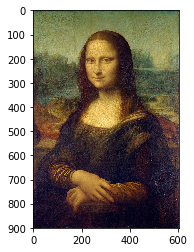

In [10]:
pic = plt.imread('604px-Mona_Lisa.jpg')
plt.imshow(pic)
pic_height, pic_width, channels = pic.shape
ground_truth = pic.reshape(-1, channels)
length, _ = ground_truth.shape
print(pic_height, pic_width, channels)
print(length, _)

### Preprocessing the Input

#### uniformly sample 5,000 random (x,y) coordinate locations as training data set

In [11]:
# sample 5000 x 5 [x, y, r, g, b]

sample_size = 5000

indexes = np.arange(length)
chosen_idx = np.random.choice(indexes, size=sample_size, replace=False)

xs = np.array([int(i / pic_width) for i in indexes])
ys = np.array([i % pic_width for i in indexes])
colors = ground_truth[chosen_idx, :].astype(np.float) / 255
train_data = np.column_stack((xs[chosen_idx], ys[chosen_idx], colors))

print(chosen_idx.shape, length)

x_train = train_data[:, :2]
y_train = train_data[:, 2:]
x_test = np.column_stack((xs , ys))
y_test = ground_truth / 255.0

# not_in_indices = [False if i in chosen_idx else True for i in range(length)]
# x_test = np.column_stack((xs[not_in_indices] , ys[not_in_indices]))
# y_test = ground_truth[not_in_indices, :] / 255.0

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

(5000,) 543600
x_train: (5000, 2)
y_train: (5000, 3)
x_test: (543600, 2)
y_test: (543600, 3)


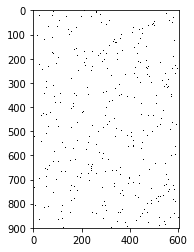

In [12]:
chosen_sample = np.ones((length ,1))
chosen_sample[chosen_idx] = 0
plt.imshow(chosen_sample.reshape(pic_height, pic_width), cmap='gray')
plt.show()

### Preprocessing the Output

#### Learn a different function for each channel

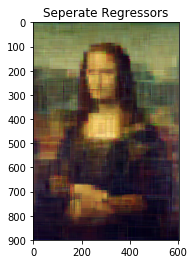

In [13]:
rfr_r = RandomForestRegressor(); rfr_r.fit(x_train, y_train[:, 0])
rfr_g = RandomForestRegressor(); rfr_g.fit(x_train, y_train[:, 1])
rfr_b = RandomForestRegressor(); rfr_b.fit(x_train, y_train[:, 2])

pred_pic = np.column_stack((rfr_r.predict(x_test), rfr_g.predict(x_test), rfr_b.predict(x_test)))
pred_pic = pred_pic.reshape(pic_height, pic_width, channels)
plt.title('Seperate Regressors')
plt.imshow(pred_pic)

#### Regress all three values at once

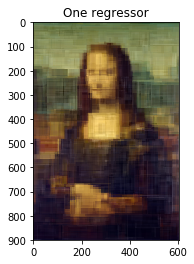

In [14]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(); rfr.fit(x_train, y_train)

pred_pic = rfr.predict(x_test).reshape(pic_height, pic_width, channels)
plt.title('One regressor')
plt.imshow(pred_pic)

### Experimentation

#### Single decision tree, but with different depths

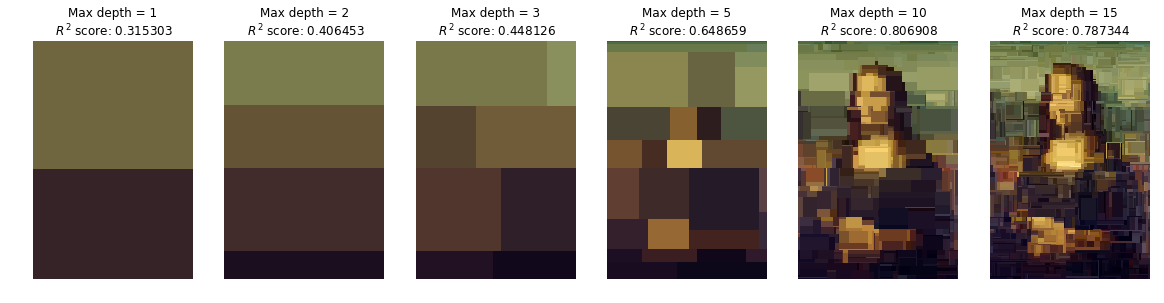

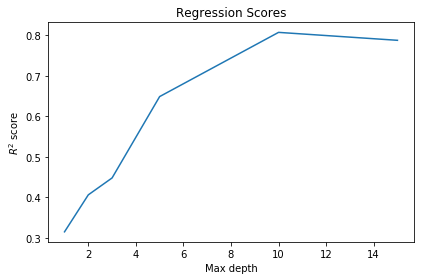

In [15]:
scores = []
depths = [1,2,3,5,10,15]

PLT_COL = 6
PLT_ROW = 1

plt.figure(figsize=[20, 10])
for i, dep in enumerate(depths):
    reg = RandomForestRegressor(n_estimators=1, max_depth=dep)
    reg.fit(x_train, y_train)
    
    pred = reg.predict(x_test).reshape(pic_height, pic_width, channels)
    score = reg.score(x_test, y_test)
    scores.append(score)
    
    plt.subplot(PLT_ROW, PLT_COL, i + 1)
    plt.imshow(pred)
    plt.axis("off")
    plt.title('Max depth = %d\n $R^2$ score: %f' % (dep, score))
    
    
plt.figure()
plt.plot(depths, scores)
plt.title('Regression Scores')
plt.ylabel('$R^2$ score')
plt.xlabel('Max depth')
plt.tight_layout()

#### Depth = 7, with different number of trees

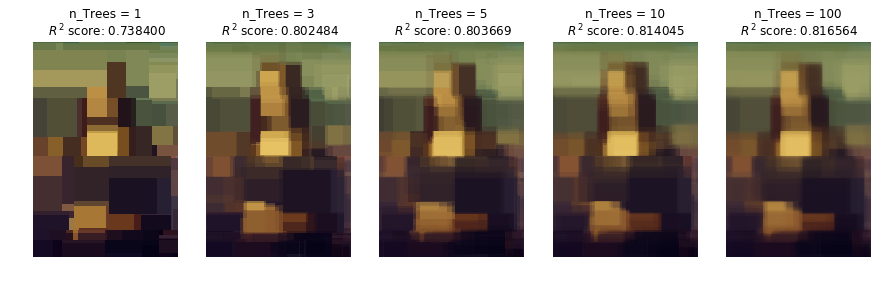

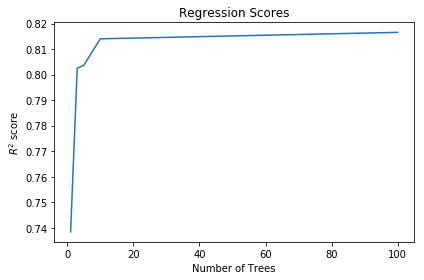

In [16]:
scores = []
num_of_trees = [1,3,5,10,100]
depth = 7

PLT_COL = 5
PLT_ROW = 1

plt.figure(figsize=[15, 10])
for i, n in enumerate(num_of_trees):
    reg = RandomForestRegressor(n_estimators=n, max_depth=depth)
    reg.fit(x_train, y_train)
    
    pred = reg.predict(x_test).reshape(pic_height, pic_width, channels)
    score = reg.score(x_test, y_test)
    scores.append(score)
    
    plt.subplot(PLT_ROW, PLT_COL, i + 1)
    plt.imshow(pred)
    plt.axis("off")
    plt.title('n_Trees = %d\n $R^2$ score: %f' % (n, score))
    
    
plt.figure()
plt.plot(num_of_trees, scores)
plt.title('Regression Scores')
plt.ylabel('$R^2$ score')
plt.xlabel('Number of Trees')
plt.tight_layout()

#### 1-NN Regressor 

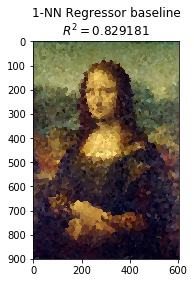

In [17]:
KNeighborsRegressor
kNN = KNeighborsRegressor(n_neighbors=1)
kNN.fit(x_train, y_train)
pred = kNN.predict(x_test).reshape(pic_height, pic_width, channels)
score = kNN.score(x_test, y_test)
plt.imshow(pred)
plt.title('1-NN Regressor baseline\n$R^2=$%f' % score)
plt.show()

#### Pruning 

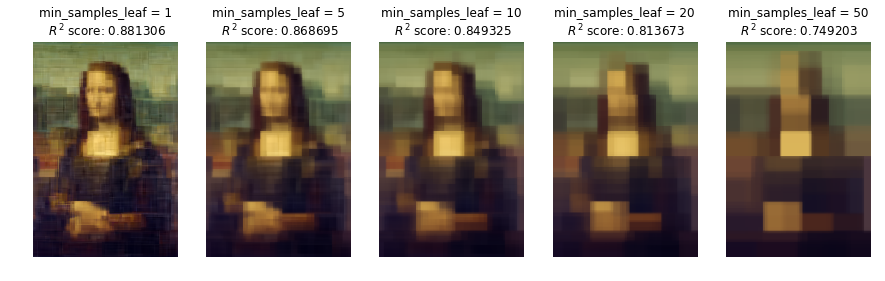

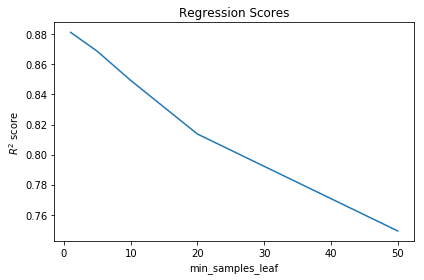

In [22]:
scores = []
num_of_trees = 50
depth = 30
leaves = [1, 5, 10, 20, 50]
PLT_COL = 5
PLT_ROW = 1

plt.figure(figsize=[15, 10])
for i, leaf in enumerate(leaves):
    reg = RandomForestRegressor(n_estimators=num_of_trees, max_depth=depth, min_samples_leaf=leaf)
    reg.fit(x_train, y_train)
    
    pred = reg.predict(x_test).reshape(pic_height, pic_width, channels)
    score = reg.score(x_test, y_test)
    scores.append(score)
    
    plt.subplot(PLT_ROW, PLT_COL, i + 1)
    plt.imshow(pred)
    plt.axis("off")
    plt.title('min_samples_leaf = %d\n $R^2$ score: %f' % (leaf, score))
    
    
plt.figure()
plt.plot(leaves, scores)
plt.title('Regression Scores')
plt.ylabel('$R^2$ score')
plt.xlabel('min_samples_leaf')
plt.tight_layout()

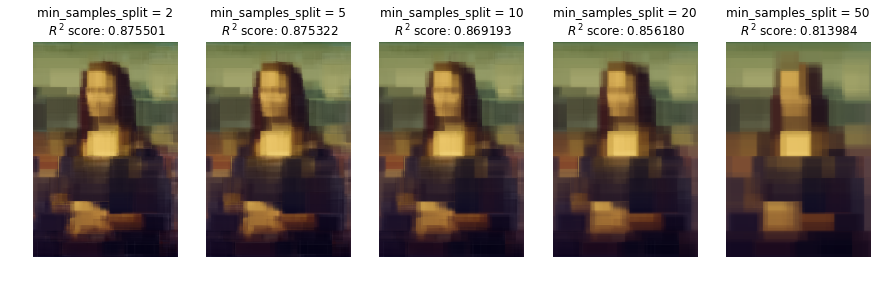

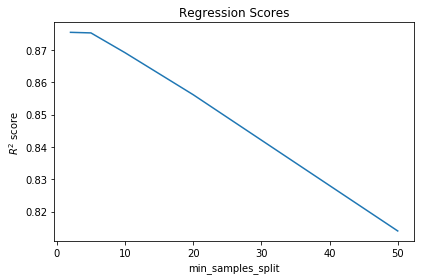

In [24]:
scores = []
num_of_trees = 50
depth = 10
splits = [2, 5, 10, 20, 50]
PLT_COL = 5
PLT_ROW = 1

plt.figure(figsize=[15, 10])
for i, split in enumerate(splits):
    reg = RandomForestRegressor(n_estimators=num_of_trees, max_depth=depth, min_samples_split=split)
    reg.fit(x_train, y_train)
    
    pred = reg.predict(x_test).reshape(pic_height, pic_width, channels)
    score = reg.score(x_test, y_test)
    scores.append(score)
    
    plt.subplot(PLT_ROW, PLT_COL, i + 1)
    plt.imshow(pred)
    plt.axis("off")
    plt.title('min_samples_split = %d\n $R^2$ score: %f' % (split, score))
    
    
plt.figure()
plt.plot(splits, scores)
plt.title('Regression Scores')
plt.ylabel('$R^2$ score')
plt.xlabel('min_samples_split')
plt.tight_layout()